In [1]:
using GaussianProcessODEs
using KernelFunctions

using DifferentialEquations
using Plots
using Optim
using LaTeXStrings

using LinearAlgebra
pyplot()

Plots.PyPlotBackend()

# Spiral ODE

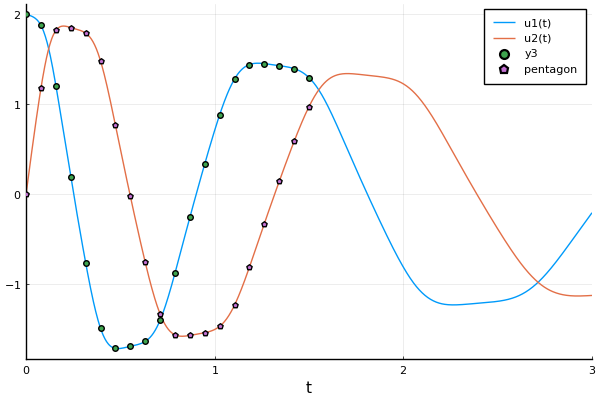

In [2]:
u0 = Float32[2.0; 0.0]
datasize = 20
tspan = (0.0f0, 3.0f0)
datatspan = (0.0f0, 1.5f0)
datatsteps = range(datatspan[1], datatspan[2], length = datasize)

function trueODEfunc!(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end
function trueODEfunc(u,p,t)
    du = similar(u)
    trueODEfunc!(du, u, p, t)
end

prob_trueode = ODEProblem(trueODEfunc!, u0, tspan)
# ode_data = Array(solve(prob_trueode, Tsit5(), saveat = tsteps))
sol = solve(prob_trueode, Tsit5())
ode_data = Array(sol(datatsteps))

traj = sol(datatsteps);

p = plot(sol)
scatter!(p,datatsteps, ode_data[1,:], markersize = 4)#, markerstyle = :star)
scatter!(p,datatsteps, ode_data[2,:], m = (4, :pentagon), lab = "pentagon")#, markerstyle = :star)

In [3]:
using Flux, DiffEqFlux

let
    global dudt2 = FastChain((x, p) -> x.^3,
                      FastDense(2, 50, tanh),
                      FastDense(50, 2))
    prob_neuralode = NeuralODE(dudt2, datatspan, Tsit5(), saveat = datatsteps)

    function predict_neuralode(p)
      Array(prob_neuralode(u0, p))
    end

    function loss_neuralode(p)
        pred = predict_neuralode(p)
        loss = sum(abs2, ode_data .- pred)
        return loss, pred
    end

    result_neuralode = DiffEqFlux.sciml_train(loss_neuralode, prob_neuralode.p,
                                              ADAM(0.05),
                                              maxiters = 300)

    result_neuralode2 = DiffEqFlux.sciml_train(loss_neuralode,
                                               result_neuralode.minimizer,
                                               DiffEqFlux.LBFGS())
    global pf = result_neuralode2.minimizer;

    global extraneuralprob = NeuralODE(dudt2, tspan, Tsit5())
    global extraneuralsol = extraneuralprob(u0, pf);
end;

In [ ]:
# get gradient observations
traj = sol(datatsteps)
data = gradient_data(traj; show_opt = true);

borders = getborders(data)
ngp = 4
Z = rectanglegrid(borders, ngp)

inDim = length(data.X[1]);

In [ ]:
nts = 110
ts = range(tspan..., length = nts)
k = 80# memory size
n = 150;

### Full GP


In [ ]:
# full gp
#26.34945342969098, 1.3424302948069182, 0.919665438925668
let
    mker = psmkernel(inDim)
    traj_sgp = SparseGP(mker, data.X, data.Y)

    gpOde = GPODE(traj_sgp, tspan, Tsit5())
    res_gpODE = train(gpOde; show_opt = true)
    
    global fullgpsol = res_gpODE(u0);
end;

## FITC

In [ ]:
# basic FITC
let
    # mker = psmkernel(inDim)
    mker = psmkernel([779.6017752888342, 2.6381334074291454, 2.6159588118755073])
    traj_sgp = SparseGP(mker, Z, data.X, data.Y; σ_n = 1e-9)
    
    global fitc_traj_sgp = train_sparsegp(traj_sgp; show_opt = true)
    global fitc_gpODE = GPODE(fitc_traj_sgp, tspan, Tsit5())    
    global fitc_gpsol = fitc_gpODE(u0) 

end;

In [ ]:
# basic FITC with zero
let
    ndata = (X=vcat(data.X, [[0f0, 0f0]]), Y=vcat(data.Y, [[0., 0.]]) )
    
    # mker = psmkernel(inDim)
    mker = psmkernel([1456.6333489090493, 2.965623835914896, 2.969681882287084])
    traj_sgp = SparseGP(mker, Z, ndata.X, ndata.Y;  σ_n = 1e-9)#, method = FITC())

    options = Optim.Options(iterations = 1000, g_tol = 1e-6, show_trace = true, show_every = 500)
    global fitc_zero_traj_sgp = train_sparsegp(traj_sgp; show_opt = true, options = options)
    global fitc_zero_goODE = GPODE(fitc_zero_traj_sgp, tspan, Tsit5()) 
    global fitc_zero_gpsol = fitc_zero_goODE(u0) 
end;
GC.gc()

## Plot

In [ ]:
p1 = plot(size = (800, 400), legend = :outerright, layout = (2,1))
lwh = 1.8
labeltext = ["truth", "NN", "FITC", "FITC+{0}", "Full GP", "data"]
labels = hcat(labeltext, fill("", length(labeltext)))
for i in 1:2
plot!(p1, sol, vars = i, subplot = i, linewidth = lwh, color = :black,
    ylabel = "x1", label = labels[1,i]) # L"$x_1$"
plot!(p1, extraneuralsol, vars = i, subplot = i, linewidth = lwh, color = :mediumseagreen, 
    label = labels[2,i])
plot!(p1, fitc_gpsol, vars = i, subplot = i, linewidth = lwh, color = :firebrick,
    label = labels[3,i])
plot!(p1, fitc_zero_gpsol, vars = i, subplot = i, linewidth = lwh, color = :firebrick, linestyle = :dash,
    label = labels[4,i])
plot!(p1, fullgpsol, vars = i, subplot = i, linewidth = lwh, color = :royalblue, linestyle = :dash,
    label = labels[5,i])
scatter!(p1, datatsteps, ode_data[i,:], subplot = i, color = :black, markersize = 3, label = labels[end,i])
    
end
p1